In [57]:
import os, shutil

import flwr as fl
import numpy as np
import torch
from omegaconf import OmegaConf, DictConfig
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
from florl.common.util import aggregate_weighted_average, stateful_client

from qtoptavg import *

sns.set_theme()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLIENTS = 5
TOTAL_ROUNDS = 400
FRAMES_PER_ROUND = 25
# EXPERIMENT_REPEATS = 30
EXPERIMENT_REPEATS = 10

config = DictConfig({
    "rl": {
        "env": {
            "name": "Pendulum-v1"
        },
        "algorithm": {
            "gamma": 0.99,
            "tau": 0.005,
            "lr": 0.001,
            "update_frequency": 1,
            "clip_grad_norm": 1,
            "critic": {
                "features": 64
            }
        },
        "memory": {
            "type": "experience_replay",
            "capacity": max(128, TOTAL_ROUNDS * FRAMES_PER_ROUND)
        },
        "train": {
            "initial_collection_size": 1024,
            "minibatch_size": 64
        }
    },
    "fl": {
        "train_config": {
            "frames": FRAMES_PER_ROUND,
        },
        "evaluate_config": {
            "evaluation_repeats": 1
        }
    }
})

train_config = OmegaConf.to_container(config["fl"]["train_config"])
evaluate_config = OmegaConf.to_container(config["fl"]["evaluate_config"])

def _on_fit_config_fn(server_round: int):
        return train_config | {"server_round": server_round}
def _on_evaluate_config_fn(server_round: int):
    return evaluate_config | {"server_round": server_round}

client_factory = QTOptClientFactory(config)

# Baseline

In [58]:
baseline_results = []
for seed in range(EXPERIMENT_REPEATS):
    client = client_factory.create_dqn_client(seed, config["rl"])

    # Manually run through the training loop
    hist_fit = []
    evaluation_reward = []
    for simulated_rounds in tqdm(range(TOTAL_ROUNDS)):
        _, metrics = client.train(config["fl"]["train_config"])
        hist_fit.append(metrics)
        evaluation_reward.append(client._evaluator.evaluate(client.policy, repeats=config["fl"]["evaluate_config"]["evaluation_repeats"]))

    baseline_results.append((hist_fit, evaluation_reward))

100%|██████████| 400/400 [02:13<00:00,  3.00it/s]


# Federated

In [59]:
CONTEXT_WS = "florl_ws"

strategy = fl.server.strategy.FedAvg(
#strategy = fl.server.strategy.FedProx(
    #proximal_mu=0.1,
    on_fit_config_fn = _on_fit_config_fn,
    on_evaluate_config_fn= _on_evaluate_config_fn,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average, 
    accept_failures=False
)

federated_results = []

for seed in tqdm(range(EXPERIMENT_REPEATS)):
    if os.path.exists(CONTEXT_WS):
        shutil.rmtree(CONTEXT_WS)

    @stateful_client
    def build_client(cid: str) -> fl.client.Client:
        cid = int(cid) + seed * NUM_CLIENTS
        return client_factory.create_dqn_client(cid, config=config["rl"])

    hist = fl.simulation.start_simulation(
        client_fn=build_client,
        client_resources={'num_cpus': 1},
        config=fl.server.ServerConfig(num_rounds=TOTAL_ROUNDS),
        num_clients = NUM_CLIENTS,
        strategy = strategy
    )

    federated_results.append(hist)

  0%|          | 0/1 [00:00<?, ?it/s]INFO flwr 2024-03-05 19:08:29,965 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=400, round_timeout=None)
2024-03-05 19:08:33,091	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-05 19:08:34,513 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 12.0, 'object_store_memory': 2838214656.0, 'node:10.255.212.67': 1.0, 'memory': 5676429312.0}
INFO flwr 2024-03-05 19:08:34,514 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-05 19:08:34,514 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO flwr 2024-03-05 19:08:34,532 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 12 actors
INFO flwr 2024-03-05 19:08:34,534 | server.py:91 | Initializing global parameters
INFO flwr 2024-03-05 19:08:34,534 | server.py:282 | Requesting ini

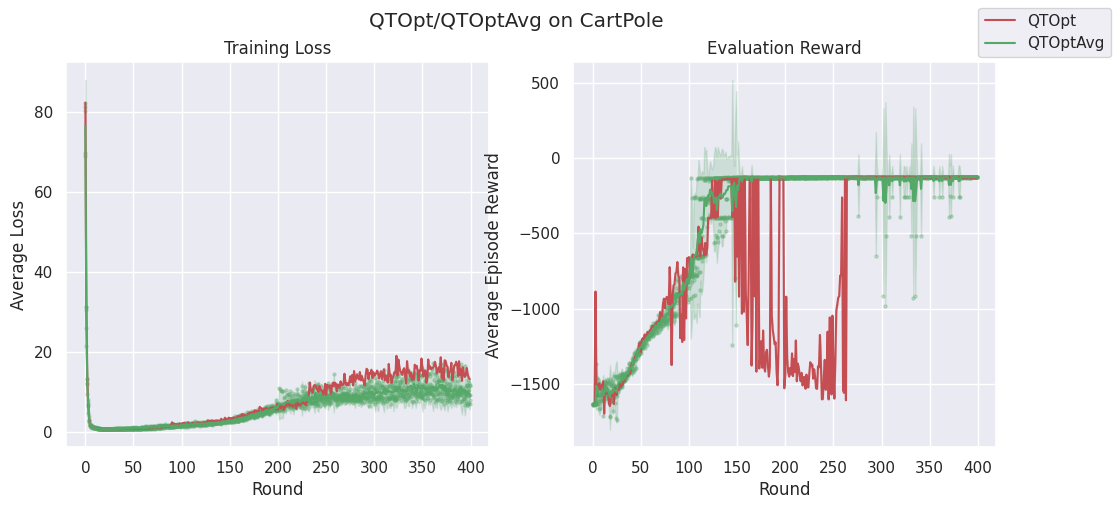

In [60]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(12,5)
fig.suptitle("QTOpt/QTOptAvg on CartPole")

rounds = list(range(TOTAL_ROUNDS))

# Loss
baseline_losses = np.array([[s['loss'] for s in ex[0]] for ex in baseline_results])
baseline_losses_mean = baseline_losses.mean(axis=0)
baseline_losses_std = baseline_losses.std(axis=0)
federated_losses = np.array([[x[1]['all'] for x in hist.metrics_distributed_fit["loss"]] for hist in federated_results])
federated_losses = federated_losses.transpose((0,2,1,3)).reshape((EXPERIMENT_REPEATS*NUM_CLIENTS, TOTAL_ROUNDS, 2))[:,:,1]
federated_losses_mean = federated_losses.mean(axis=0)
federated_losses_std = federated_losses.std(axis=0)

ax = axs[0]
ax.plot(rounds, baseline_losses_mean, color="r", label="QTOpt")
ax.fill_between(
    x=rounds,
    y1=baseline_losses_mean-baseline_losses_std*1.96,
    y2=baseline_losses_mean+baseline_losses_std*1.96,
    alpha=0.2,
    color="r"
)
ax.plot(rounds, federated_losses_mean, color="g", label="QTOptAvg")
for i in range(NUM_CLIENTS):
    ax.scatter(rounds, federated_losses[i], color="g", alpha=0.3, s=5)
ax.fill_between(
    x=rounds,
    y1=federated_losses_mean-federated_losses_std*1.96,
    y2=federated_losses_mean+federated_losses_std*1.96,
    alpha=0.2,
    color="g"
)
ax.set_title("Training Loss")
ax.set_ylabel("Average Loss")
ax.set_xlabel("Round")

# Evaluation Reward
baseline_rewards = np.array([ex[1] for ex in baseline_results])
baseline_rewards_mean = baseline_rewards.mean(axis=0)
baseline_rewards_std = baseline_rewards.std(axis=0)
federated_rewards = np.array([[x[1]['all'] for x in hist.metrics_distributed["reward"]] for hist in federated_results])
federated_rewards = federated_rewards.transpose((0,2,1,3)).reshape((EXPERIMENT_REPEATS*NUM_CLIENTS, TOTAL_ROUNDS, 2))[:,:,1]
federated_rewards_mean = federated_rewards.mean(axis=0)
federated_rewards_std = federated_rewards.std(axis=0)

ax = axs[1]
ax.plot(rounds, baseline_rewards_mean, color="r", label="QTOpt")
ax.fill_between(
    x=rounds,
    y1=baseline_rewards_mean-baseline_rewards_std*1.96,
    y2=baseline_rewards_mean+baseline_rewards_std*1.96,
    alpha=0.2,
    color="r"
)
ax.plot(rounds, federated_rewards_mean, color="g", label="QTOptAvg")
for i in range(NUM_CLIENTS):
    ax.scatter(rounds, federated_rewards[i], color="g", alpha=0.3, s=5)
ax.fill_between(
    x=rounds,
    y1=federated_rewards_mean-federated_rewards_std*1.96,
    y2=federated_rewards_mean+federated_rewards_std*1.96,
    alpha=0.2,
    color="g"
)
ax.set_title("Evaluation Reward")
ax.set_ylabel("Average Episode Reward")
ax.set_xlabel("Round")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')